<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/MLP_ON_VISION_DATASETS/Wrapped_up_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 7.6 MB/s 


In [2]:

!pip install -U scikit-learn --user



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.anaconda.org/scipy-wheels-nightly/simple


In [4]:
# libary imports 
import os
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset

plt.rcParams['figure.figsize'] = [10, 20]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Main program

In [17]:


# Prepare CIFAR-10 dataset
trainset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


#print(images, labels)

def my_fun(dataset):
    X=[]
    y=[]
    for feature, label in iter(dataset):
        X.append(feature)
        y.append(label)
    return torch.stack(X).numpy(), y


#get  data as numpy arrays
X_train, y_train = my_fun(trainset)
X_test, y_test =my_fun(testset)


Files already downloaded and verified
Files already downloaded and verified


In [325]:
class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(
        self,
        input_dim=trainset.data[1].shape,
        output_dim=len(torch.unique(torch.tensor(trainset.targets))),
        first_hidden_dimension=64,
        #if you only want to add  a single hidden layer you do the following:
       # hidden_layers=((32),)
        hidden_layers=((32),),
        ):
        super().__init__()
        #self.modules1 = torch.nn.ModuleList([])
        self.residual=False
        self.hidden_layer_num=len(hidden_layers)
        self.d_in=reduce(operator.mul, input_dim)
        if self.hidden_layer_num>0:
            self.h_0=first_hidden_dimension
            self.h_n=hidden_layers[-1]
 
        else: 
            self.h_0=self.h_n=first_hidden_dimension
      

        self.linear1=nn.Linear(self.d_in,  self.h_0)
        self.relu=torch.nn.ReLU()
        self.hidden_linear=[]
        if self.hidden_layer_num>0:
          in_channels=self.h_0
          for h_dim in list(hidden_layers):
              #self.modules1.append(nn.Linear(in_channels, in_channels))
              self.hidden_linear.append(torch.nn.Linear(in_channels, h_dim))
              in_channels = h_dim
        self.hidden_linear=nn.ModuleList(self.hidden_linear)
        self.linear2=nn.Linear( self.h_n, output_dim)
        #self.modules1.append(nn.Linear( self.h_n, output_dim))
     

      def forward(self, x):
        x=x.view(-1, reduce(operator.mul, self.d_in))
        x=self.linear1(x)
        x=self.relu(x)
        if self.hidden_layer_num>0:
          for linear in self.hidden_linear:
            if self.residual:
              x=self.relu(linear(x)) + x
          else:
              x = self.relu(linear(x))
        return  F.log_softmax(self.linear2(x), dim=1)

In [ ]:
class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(self ):
        super().__init__()
        input=trainset.data[1].shape
        output=len(torch.unique(torch.tensor(trainset.targets)))
        hidden_layer_sizes=(64,32)
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(reduce(operator.mul, input),  hidden_layer_sizes[0]),
          nn.ReLU(),
          nn.Linear(hidden_layer_sizes[0],  hidden_layer_sizes[1]),
          nn.ReLU(),
          nn.Linear(hidden_layer_sizes[1], output)
        )

      def forward(self, x):
        '''Forward pass'''
        return self.layers(x)


In [109]:
mlp=MLPClassifer
mlp.state_dict() 

OrderedDict([('modules1.0.weight',
              tensor([[-0.0164, -0.0095, -0.0042,  ..., -0.0033,  0.0166, -0.0161],
                      [ 0.0023, -0.0171,  0.0139,  ..., -0.0144, -0.0101,  0.0019],
                      [-0.0093,  0.0045,  0.0174,  ...,  0.0074,  0.0106,  0.0090],
                      ...,
                      [-0.0178, -0.0159,  0.0157,  ..., -0.0014, -0.0011,  0.0113],
                      [-0.0133,  0.0131, -0.0169,  ..., -0.0082,  0.0167,  0.0178],
                      [-0.0049,  0.0028,  0.0130,  ..., -0.0161, -0.0013, -0.0013]])),
             ('modules1.0.bias',
              tensor([ 0.0040,  0.0079, -0.0159, -0.0129,  0.0147,  0.0158, -0.0145, -0.0174,
                       0.0143,  0.0163, -0.0144, -0.0022, -0.0032,  0.0095, -0.0168, -0.0096,
                       0.0131, -0.0071,  0.0119,  0.0003,  0.0005,  0.0058,  0.0101, -0.0105,
                       0.0059,  0.0164, -0.0170, -0.0044,  0.0068,  0.0049,  0.0037, -0.0123,
                      

In [327]:
class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(
        self,
        input_dim=trainset.data[1].shape,
        output_dim=len(torch.unique(torch.tensor(trainset.targets))),
        first_hidden_dimension=64,
        #if you only want to add  a single hidden layer you do the following:
       # hidden_layers=((32),)
        hidden_layers=((32),),
        ):
        super().__init__()
        #self.modules1 = torch.nn.ModuleList([])
        self.residual=False
        self.hidden_layer_num=len(hidden_layers)
        self.d_in=reduce(operator.mul, input_dim)
        if self.hidden_layer_num>0:
            self.h_0=first_hidden_dimension
            self.h_n=hidden_layers[-1]
 
        else: 
            self.h_0=self.h_n=first_hidden_dimension
      

        self.linear1=nn.Linear(self.d_in,  self.h_0)
        self.relu=torch.nn.ReLU()
        self.hidden_linear=[]
        if self.hidden_layer_num>0:
          in_channels=self.h_0
          for h_dim in list(hidden_layers):
              #self.modules1.append(nn.Linear(in_channels, in_channels))
              self.hidden_linear.append(torch.nn.Linear(in_channels, h_dim))
              in_channels = h_dim
        self.hidden_linear=nn.ModuleList(self.hidden_linear)
        self.linear2=nn.Linear( self.h_n, output_dim)
        #self.modules1.append(nn.Linear( self.h_n, output_dim))
     

      def forward(self, x):
        x=x.view(-1, reduce(operator.mul, self.d_in))
        x=self.linear1(x)
        x=self.relu(x)
        if self.hidden_layer_num>0:
          for linear in self.hidden_linear:
            if self.residual:
              x=self.relu(linear(x)) + x
          else:
              x = self.relu(linear(x))
        return  F.log_softmax(self.linear2(x), dim=1)

        

class Neural_Network(object):
    
    
    def __init__ (self,batch_size=2000,epochs=2,verbose=True,loss_function = nn.CrossEntropyLoss(),
         optimiser='adam',classifier= MLPClassifer(), 
         learning_rate=1e-3,  betas=(0.9,0.99) , eps=1e-8, weight_decay=0, amsgrad=False,
      momentum=0.9, nesterov=True, dampening=0, maximise=False):
      
      self.batch_size=batch_size
      self.epochs=epochs
      
      self.verbose=True
      #used inside the training/ testing loops
      self.running_loss = 0
      self.loss_function = loss_function
      self.classifier= classifier
      
      self.sm = torch.nn.Softmax()

      #some initial parameters for either standard optimisers
      self.learning_rate=learning_rate 
      self.betas= betas
      self.eps= eps
      self.weight_decay=weight_decay
      self.amsgrad=amsgrad 
      self.momentum=momentum
      self.nesterov=nesterov
      self.dampening=dampening
      self.maximise=maximise

      #default optimiser: adam 
      self.optimiser=self.set_optimiser(optimiser)
    
    #for some reason calling this function set_optimiser returns None 
    def set_optimiser(self, optimiser):
        #playing around with adam and sgd only at the moment
        #there is only two of them 
        if optimiser.lower().strip()=='adam':
            self.optimiser=torch.optim.Adam(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad)
        elif optimiser.lower().strip()=='sgd':
            self.optimiser=torch.optim.SGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9,nesterov=self.nesterov , dampening=self.dampening)
        return self.optimiser


    def get_optimiser(self):
      print(self.optimiser)

    
    def get_params(self): #get parameters
       if (self.optimiser != None) :
         return  (self.props(),self.optimiser.state_dict(), self.classifier.state_dict)
       else: return self.classifier.state_dict() 
  
    def fit(self,X,y):
        train = [*zip(X,y)]
        trainloader =  torch.utils.data.DataLoader(train,batch_size=8, shuffle=False, num_workers=2)
        for epoch in range(self.epochs):  # loop over the dataset 2 times
        
          running_loss =self.running_loss
          for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
             
            # zero the parameter gradients
            self.optimiser.zero_grad()

            # forward + compute loss+ backward + optimize
            outputs = self.classifier(inputs)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimiser.step()
            # print statistics
            running_loss += loss.item()
            if i % self.batch_size == (self.batch_size-1):    # print every "batch_size" mini-batches
                if self.verbose==True:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / self.batch_size:.3f}')
                running_loss = 0.0

    def predict(self, X_test): #Predict using the multi-layer perceptron classifier.
      test = [*zip(X_test,y_test)]
      testloader = torch.utils.data.DataLoader(test, shuffle=False)
      prediction_list=[]
      # again no gradients needed
      with torch.no_grad():
          for data in testloader:
              images, labels = data
              outputs = self.classifier(images)
              estimation, predictions = torch.max(outputs, 1)
              prediction_list.append(predictions)
      return prediction_list #torch.stack(prediction_list)


    def predict_log_proba(self,X):  #	Return the log of probability estimates.
        data = [*zip(X,y_test)]
        loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
        y_prob=self.predict_proba(loader)
        log_proba=np.log(y_prob)
        return log_proba
 

    def predict_proba(self,X_test):	#Probability estimates.
      probabilities_list=[]
      data = [*zip(X_test,y_test)]
      loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
      # again no gradients needed
      with torch.no_grad():
          for data in loader:
              images, labels = data
              outputs = self.classifier(images)
              probabilities_list.append(self.sm(outputs) )
              estimation, predictions = torch.max(outputs, 1)
      return probabilities_list
      

    def score(self,X,y): #Return the mean accuracy on the given test data and labels.
        prediction_list=[]
        targets_list=[]
        data = [*zip(X,y)]
        loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
        num_classes=len(torch.unique(torch.tensor(y)))
        #set it to true if you have a list of available labels in text format
        labels_available=False
        if labels_available:
            classes = ('plane', 'car', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            # prepare to count predictions for each class
            correct_pred = {classname: 0 for classname in classes}
            total_pred = {classname: 0 for classname in classes}
        #use the class number as key
        else: 
            classes=tuple(np.arange(num_classes))  
            correct_pred = {classname: 0 for classname in np.arange(num_classes)}
            total_pred= {classname: 0 for classname in np.arange(num_classes)}

        # again no gradients needed
        with torch.no_grad():
            for data in loader:
                images, labels = data
                targets_list.append(labels)
                outputs = self.classifier(images)
                estimation, predictions = torch.max(outputs, 1)
                prediction_list.append(predictions)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1
        accuracies={}
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            accuracies[classname]=accuracy
            if self.verbose:
              print(f'Accuracy for class: {classname} is {accuracy:.1f} %')
        return targets_list,prediction_list
        

    def set_params(self, attr, value): #sets parameters
        setattr(self, attr, value)
        
    def props(cls):   
        return [i for i in cls.__dict__.items() if i[:1] != '_']

    def get_classifier(self):
        return self.classifier()


    def get_classification_report(self,y, y_pred):
        y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
        y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()   
        print(classification_report(y_prime, y_pred_prime))


    def plot_confusion_matrix(self,cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()


    def get_confusion_matrix(self,y, y_pred, plot=True):
          y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
          y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()
          cnf_matrix = confusion_matrix(y_prime, y_pred_prime,labels=np.arange(10))
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          if plot==True:
            plt.figure()
            self.plot_confusion_matrix(cnf_matrix, classes=['plane', 'car', 'bird', 'cat',
                                'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
                                  title='Confusion matrix, without normalization')
              


In [12]:
model= Neural_Network()


In [11]:
model= Neural_Network()
model.set_optimiser('adam')
model.fit(X_train,y_train)


[1,  2000] loss: 1.802
[1,  4000] loss: 1.653
[1,  6000] loss: 1.623
[2,  2000] loss: 1.557
[2,  4000] loss: 1.505
[2,  6000] loss: 1.509


In [13]:
y, y_pred=model.score(X_test, y_test)

Accuracy for class: 0 is 44.8 %
Accuracy for class: 1 is 62.0 %
Accuracy for class: 2 is 21.5 %
Accuracy for class: 3 is 49.9 %
Accuracy for class: 4 is 38.9 %
Accuracy for class: 5 is 24.7 %
Accuracy for class: 6 is 59.9 %
Accuracy for class: 7 is 64.8 %
Accuracy for class: 8 is 74.5 %
Accuracy for class: 9 is 52.5 %


In [26]:
labels,predicted_labels=model.predict(X_test)

#If you want to convert them  to list to work on scipy
np.stack([np.stack([d for d in d_]) for d_ in labels]).flatten()
np.stack([np.stack([d for d in d_]) for d_ in predicted_labels]).flatten()

array([6, 9, 9, ..., 9, 1, 1])

In [23]:
print(x_0)
print(len(x_0))

[tensor([6]), tensor([1]), tensor([9]), tensor([6]), tensor([8]), tensor([9]), tensor([6]), tensor([7]), tensor([8]), tensor([6]), tensor([4]), tensor([4]), tensor([7]), tensor([1]), tensor([7]), tensor([8]), tensor([9]), tensor([3]), tensor([3]), tensor([6]), tensor([0]), tensor([3]), tensor([3]), tensor([6]), tensor([2]), tensor([3]), tensor([3]), tensor([1]), tensor([4]), tensor([3]), tensor([1]), tensor([9]), tensor([1]), tensor([3]), tensor([4]), tensor([7]), tensor([7]), tensor([7]), tensor([8]), tensor([8]), tensor([3]), tensor([3]), tensor([4]), tensor([7]), tensor([9]), tensor([1]), tensor([1]), tensor([8]), tensor([2]), tensor([0]), tensor([6]), tensor([6]), tensor([7]), tensor([1]), tensor([4]), tensor([2]), tensor([3]), tensor([6]), tensor([2]), tensor([8]), tensor([8]), tensor([1]), tensor([8]), tensor([6]), tensor([1]), tensor([1]), tensor([7]), tensor([9]), tensor([7]), tensor([8]), tensor([2]), tensor([6]), tensor([9]), tensor([4]), tensor([2]), tensor([4]), tensor([9])

In [25]:
print(y_0)
print(len(y_0))
print(len(X_test))

[tensor([6]), tensor([9]), tensor([9]), tensor([4]), tensor([1]), tensor([1]), tensor([2]), tensor([7]), tensor([8]), tensor([3]), tensor([4]), tensor([7]), tensor([7]), tensor([2]), tensor([9]), tensor([9]), tensor([9]), tensor([3]), tensor([2]), tensor([6]), tensor([4]), tensor([3]), tensor([6]), tensor([6]), tensor([2]), tensor([6]), tensor([3]), tensor([5]), tensor([4]), tensor([0]), tensor([0]), tensor([9]), tensor([1]), tensor([3]), tensor([4]), tensor([0]), tensor([3]), tensor([7]), tensor([3]), tensor([3]), tensor([5]), tensor([2]), tensor([2]), tensor([7]), tensor([1]), tensor([1]), tensor([1]), tensor([2]), tensor([2]), tensor([0]), tensor([9]), tensor([5]), tensor([7]), tensor([9]), tensor([2]), tensor([2]), tensor([5]), tensor([2]), tensor([4]), tensor([3]), tensor([1]), tensor([1]), tensor([8]), tensor([2]), tensor([1]), tensor([1]), tensor([4]), tensor([9]), tensor([7]), tensor([8]), tensor([5]), tensor([9]), tensor([6]), tensor([7]), tensor([3]), tensor([1]), tensor([9])

In [40]:
np.stack([np.stack([d for d in d_]) for d_ in x]).flatten()

array([6, 1, 9, ..., 9, 1, 1])

In [ ]:
'''
#  full tensor form
y_prime=torch.stack(y)
y_pred_prime=torch.stack(y_pred)

# full numpy form
y_prime= y_prime.numpy()
y_pred_numpy= y_pred_prime.numpy()
'''

'\n#  full tensor form\ny_prime=torch.stack(y)\ny_pred_prime=torch.stack(y_pred)\n\n# full numpy form\ny_prime= y_prime.numpy()\ny_pred_numpy= y_pred_prime.numpy()\n'

In [ ]:
model.get_classification_report(y, y_pred)

              precision    recall  f1-score   support

           0       0.62      0.55      0.59      5000
           1       0.64      0.62      0.63      5000
           2       0.51      0.22      0.30      5000
           3       0.32      0.49      0.39      5000
           4       0.49      0.44      0.46      5000
           5       0.46      0.29      0.36      5000
           6       0.50      0.63      0.56      5000
           7       0.56      0.66      0.60      5000
           8       0.64      0.68      0.66      5000
           9       0.55      0.64      0.59      5000

    accuracy                           0.52     50000
   macro avg       0.53      0.52      0.51     50000
weighted avg       0.53      0.52      0.51     50000



Confusion matrix, without normalization
[[2347  250  177  305  195   82  130  264  948  302]
 [ 107 2755   54  238   51   37  185  117  463  993]
 [ 413   91 1065  864  829  293  754  437  173   81]
 [ 113  108  228 2496  241  517  698  300  167  132]
 [ 190   91  306  512 2107  152  807  546  218   71]
 [  74   57  272 1864  296 1273  497  476  117   74]
 [  43   62  187  818  478  116 3032  132   61   71]
 [  82  117  131  487  434  234  159 3125   85  146]
 [ 278  267   58  255   89   60   82   59 3557  295]
 [ 116  562   55  359   47   85  180  301  529 2766]]


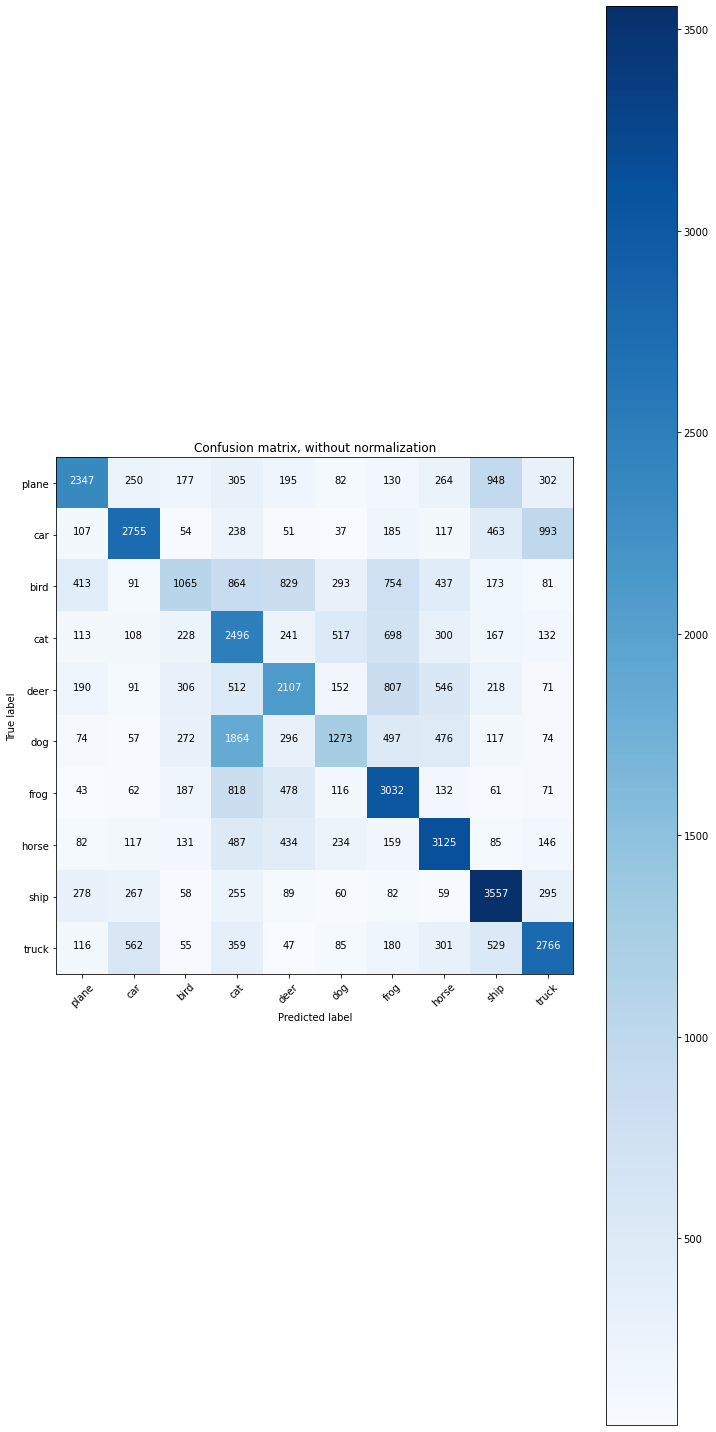

In [ ]:
model.get_confusion_matrix(y, y_pred)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()
multilabel_confusion_matrix(y_prime, y_pred_prime)

6
50000


array([[[43997,  1003],
        [ 2985,  2015]],

       [[43397,  1603],
        [ 2183,  2817]],

       [[43377,  1623],
        [ 3802,  1198]],

       [[38833,  6167],
        [ 2339,  2661]],

       [[42319,  2681],
        [ 2935,  2065]],

       [[44019,   981],
        [ 3918,  1082]],

       [[42074,  2926],
        [ 2156,  2844]],

       [[41563,  3437],
        [ 1705,  3295]],

       [[42068,  2932],
        [ 1297,  3703]],

       [[42829,  2171],
        [ 2204,  2796]]])

In [ ]:
m=torch.stack(X_train)
m=m.numpy()
len(m)
len(y_train)

50000

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


clf = make_pipeline( model)
clf.fit(X_train,  y_train)

[1,  2000] loss: 1.818
[1,  4000] loss: 1.659
[1,  6000] loss: 1.634
[2,  2000] loss: 1.556
[2,  4000] loss: 1.516
[2,  6000] loss: 1.523


Pipeline(steps=[('neural_network',
                 <__main__.Neural_Network object at 0x7f701e430d10>)])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred,y_test_prime =clf.predict(X_test)
y_pred=(torch.stack(y_pred)).numpy()
y_test_prime=(torch.stack(y_test_prime)).numpy()



##Multiclass multiouput not supported so implemented my own get_confusion_matrix_method


MLP has no Roc curve -no .decision_function()

In [ ]:
cm = confusion_matrix(y_test_prime, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

NameError: ignored

AttributeError: ignored